In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from sklearn.model_selection import train_test_split

In [2]:
data_dir = '../data/Screwdriving Model Experiments'
out_dir = '../data/sindy-data'
observation_file = 'smoothed_observation_data.csv'
sensor_file = 'sensor_data.csv'
merged_file = 'merged_data.csv'
train_file = 'train_data.csv'
validation_file = 'val_data.csv'
test_file = 'test_data.csv'
subdirs = os.listdir(data_dir)
files = list(map(lambda sd: os.path.join(data_dir, sd, observation_file), subdirs))
# files

In [3]:
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
# df.head()

In [4]:
df.isna().sum()

time    0
X       0
Y       0
Z       0
dtype: int64

In [5]:
# df.describe()

4.57769


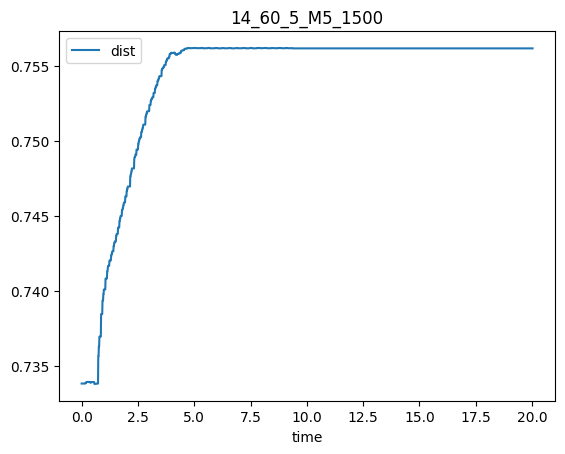

2.903985


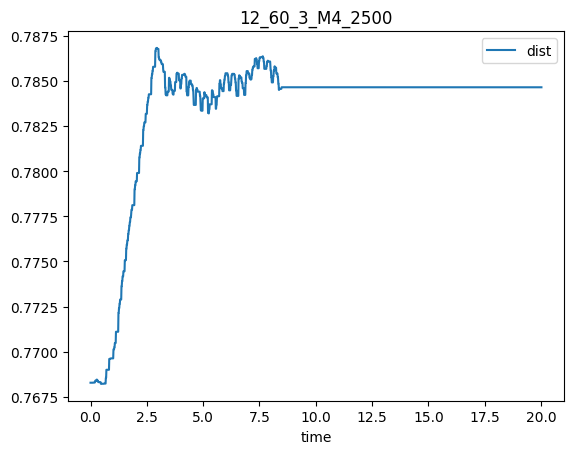

3.322185


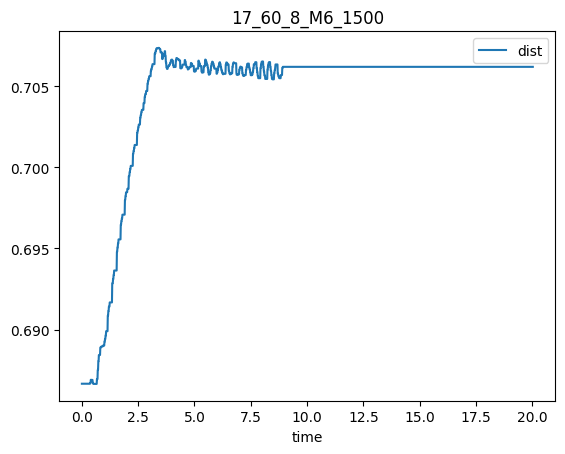

8.511759


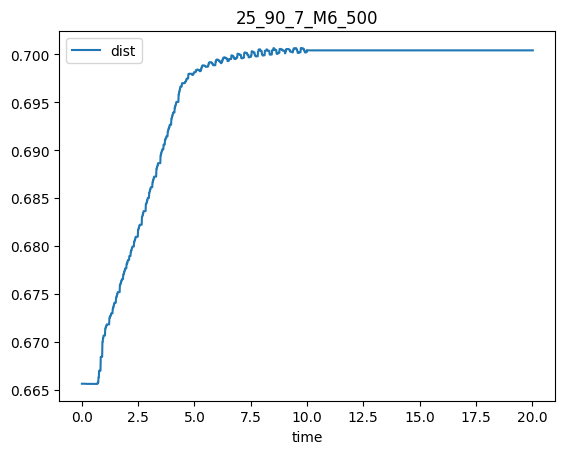

0.0


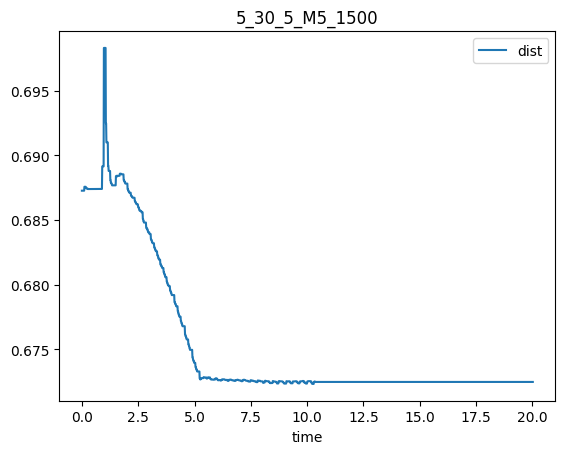

3.833257


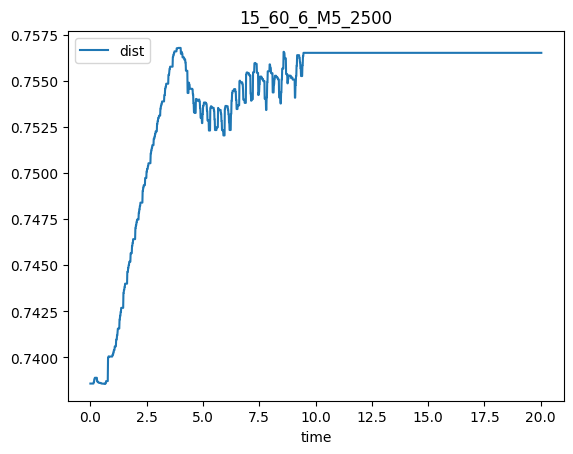

5.31185


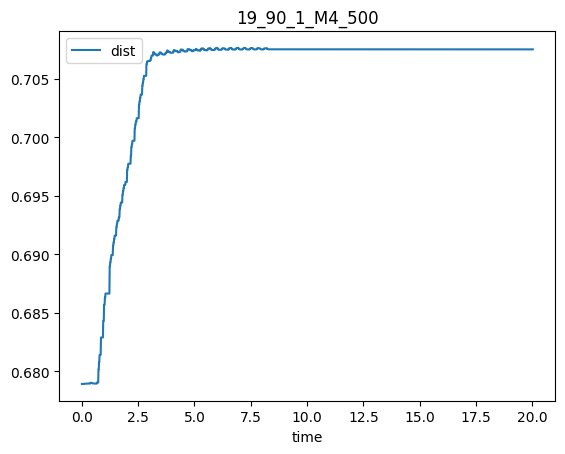

0.0


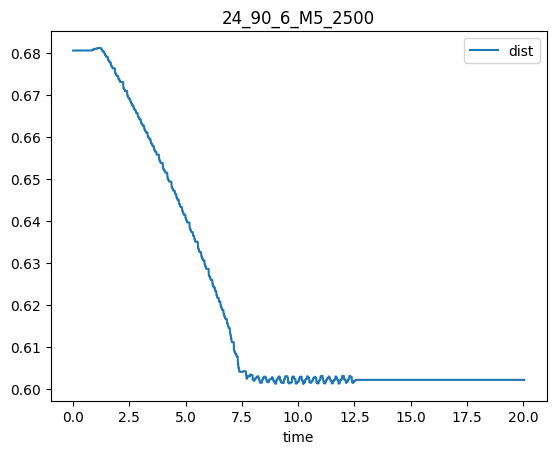

0.0


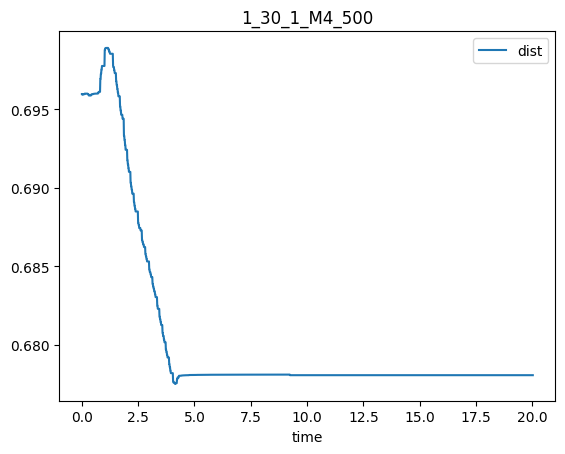

3.277385


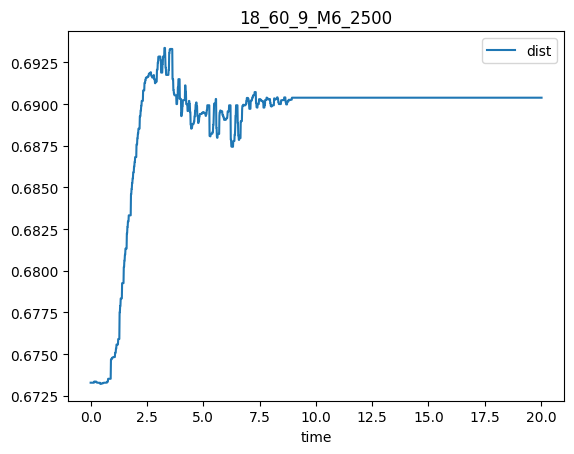

0.0


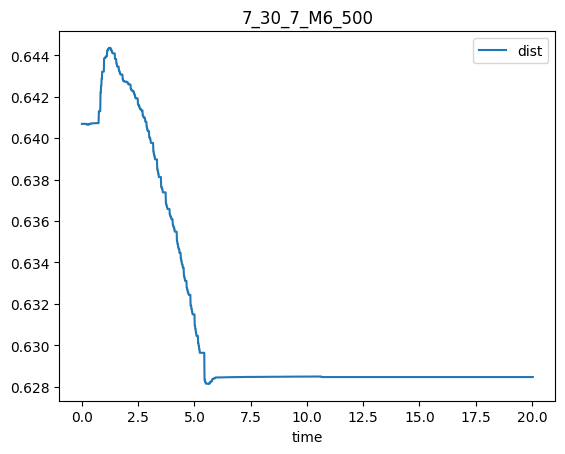

4.111444


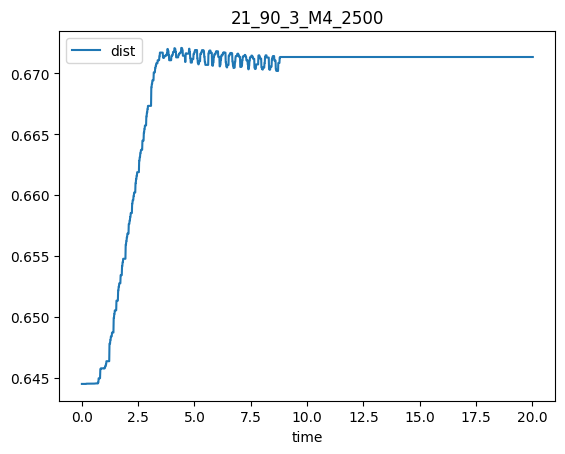

3.083161


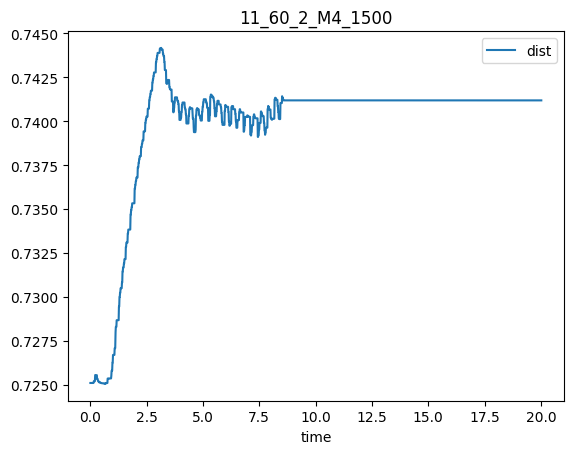

0.0


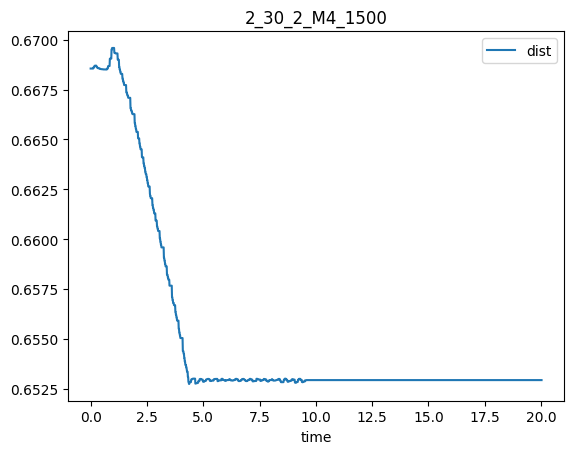

3.332682


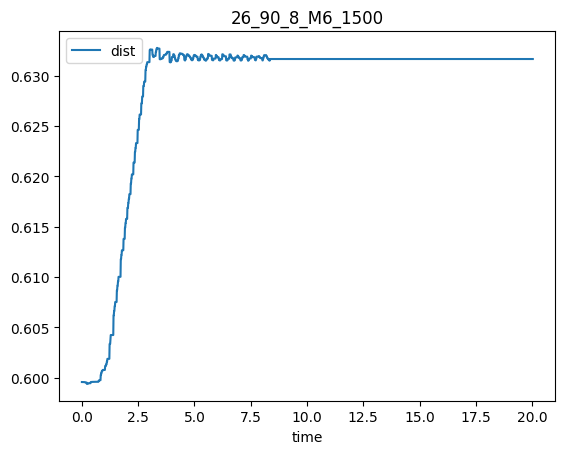

0.0


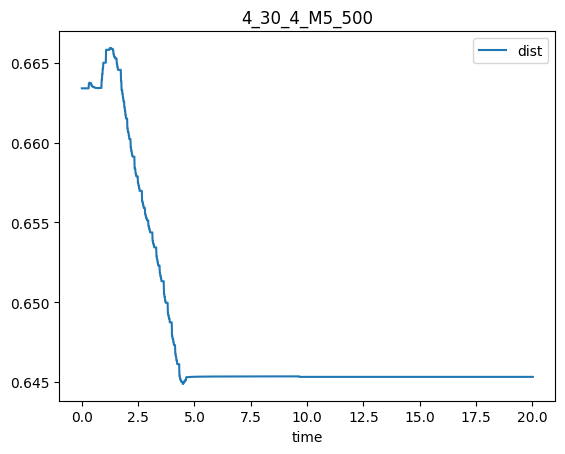

0.0


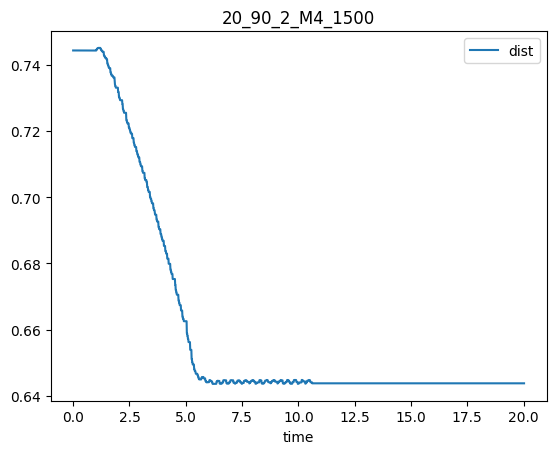

4.278586


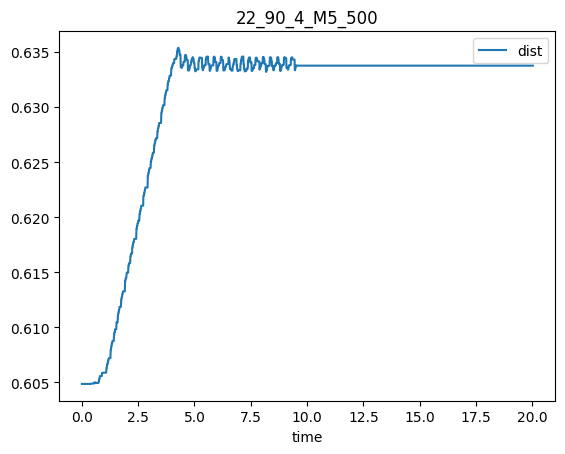

0.0


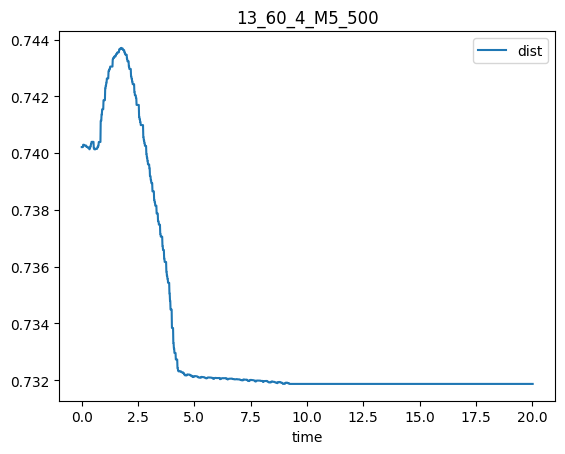

3.723399


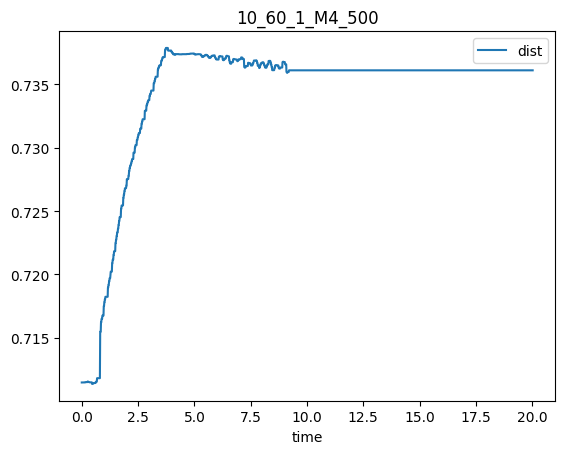

3.746236


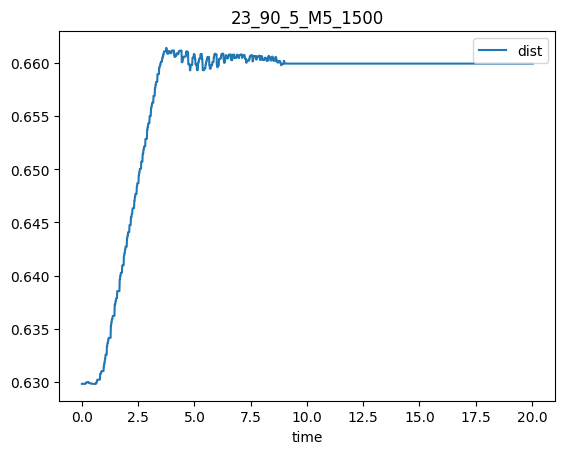

0.0


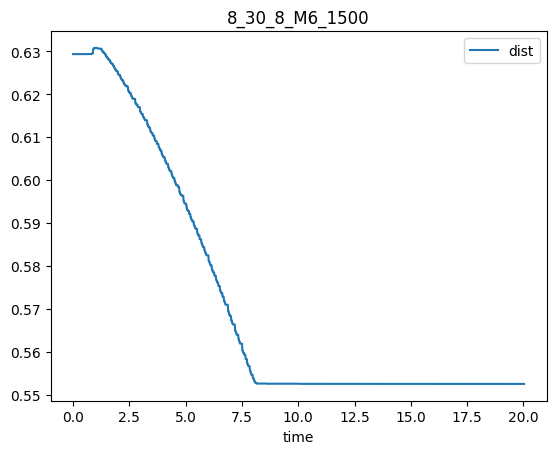

0.0


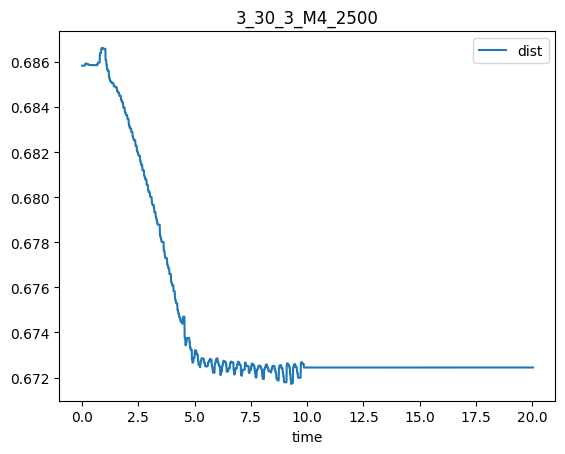

0.0


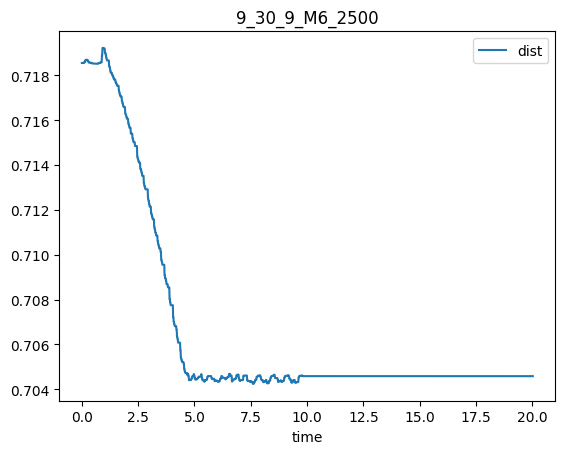

3.45216


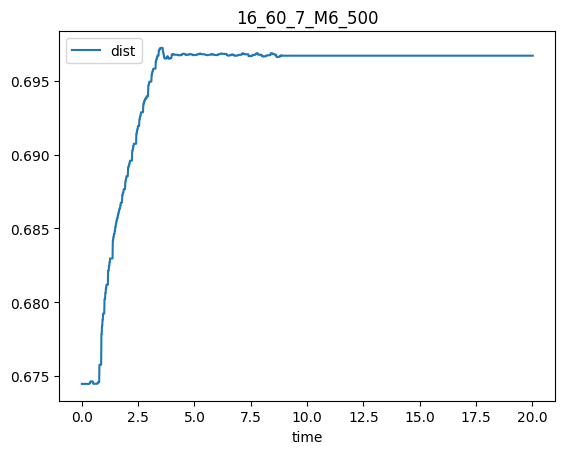

3.756909


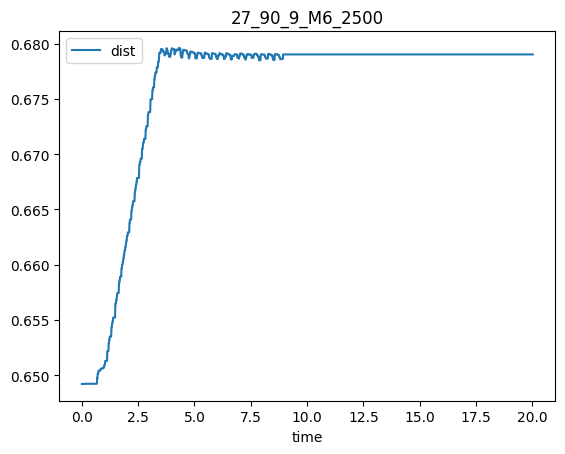

0.0


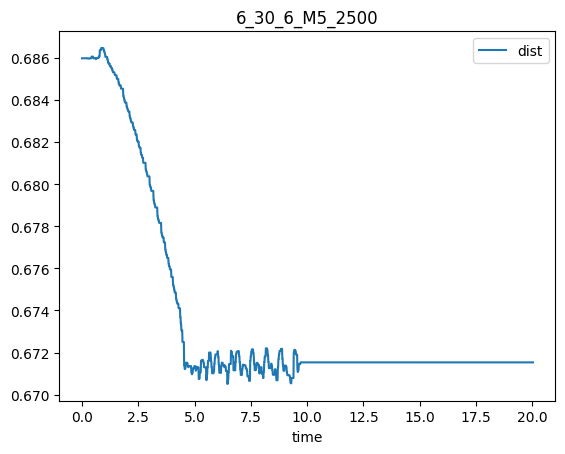

In [6]:
for subdir in subdirs:

    observation_path = os.path.join(data_dir, subdir, observation_file)
    sensor_path = os.path.join(data_dir, subdir, sensor_file)
    
    obs_df = pd.read_csv(observation_path)
    sen_df = pd.read_csv(sensor_path)
    obs_df['ref_time'] = pd.to_datetime(obs_df['time'], unit='ms')
    obs_df = obs_df.sort_values(by='time', ascending=True)
    sen_df['time'] = pd.to_datetime(sen_df['time'])
    obs_df['ref_time'] = (obs_df['ref_time'] - obs_df['ref_time'].min()).dt.total_seconds()
    sen_df['time'] = (sen_df['time'] - sen_df['time'].iloc[0]).dt.total_seconds()
    sen_df['dist'] = np.sqrt(sen_df['X'] ** 2 + sen_df['Y'] ** 2 + sen_df['Z'] ** 2)

    is_increasing = sen_df['dist'].iloc[-1] - sen_df['dist'].iloc[0] > 0
    tp_idx = sen_df[sen_df['dist'] >= 0.9999 * sen_df['dist'].max()].index.min() if is_increasing else \
        sen_df[sen_df['dist'] >= 1.0001 * sen_df['dist'].min()].index.min()

    print(sen_df.iloc[tp_idx]['time'])

    sen_df.plot(x='time', y=['dist'], kind='line')
    plt.title(label=subdir)
    plt.show()

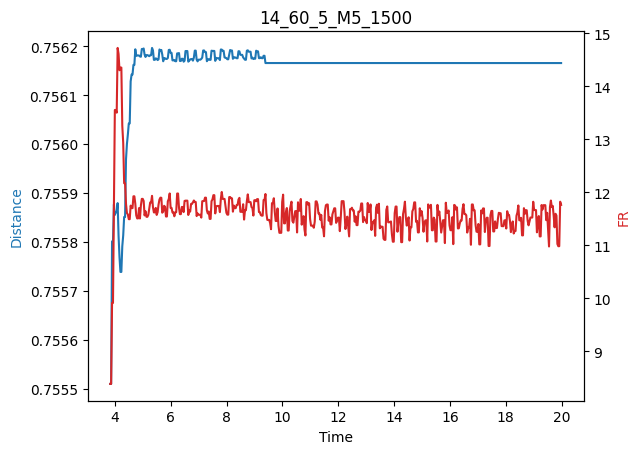

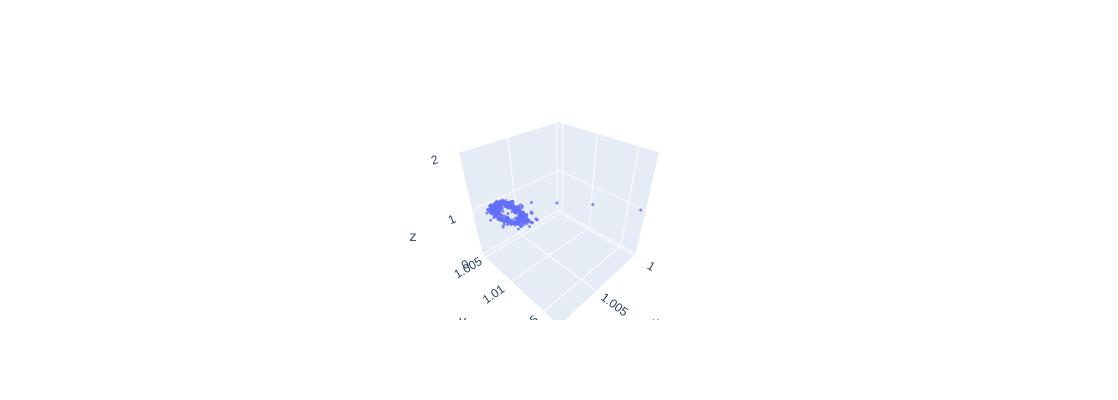

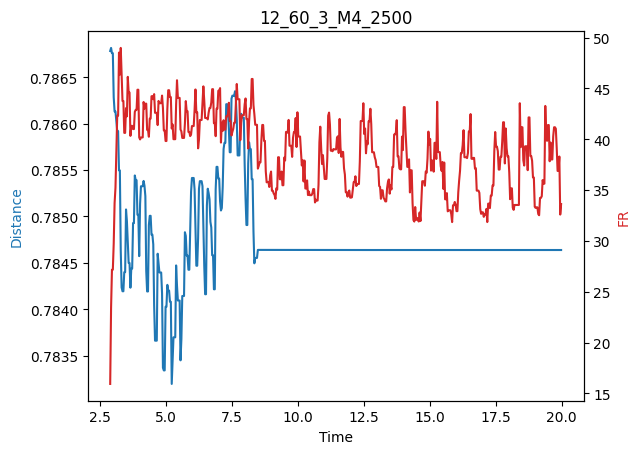

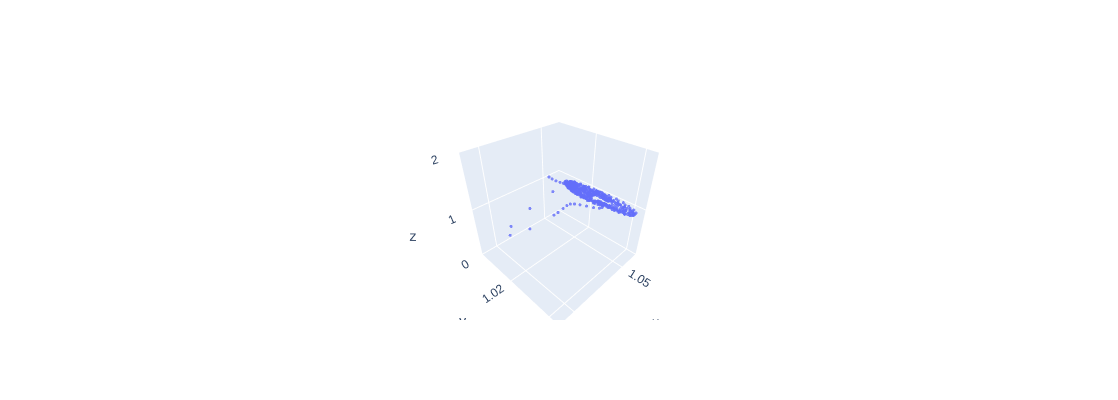

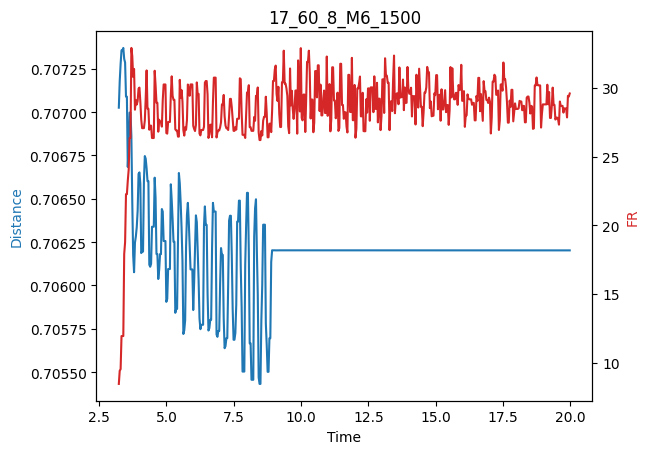

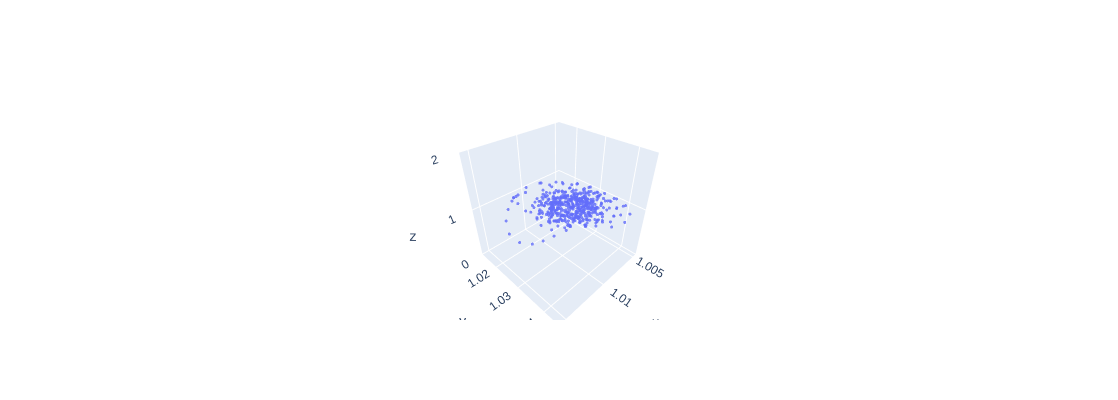

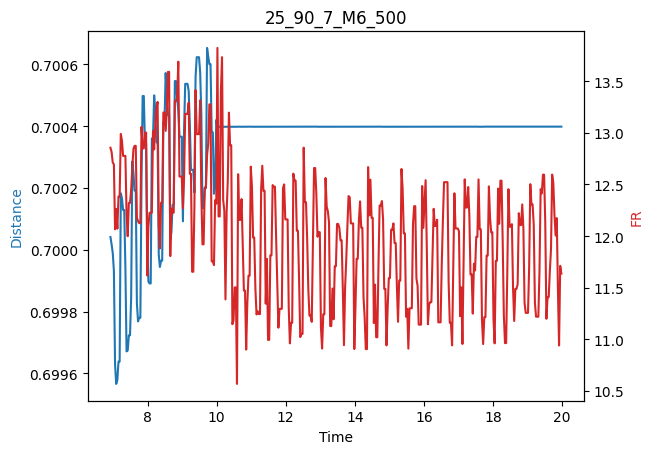

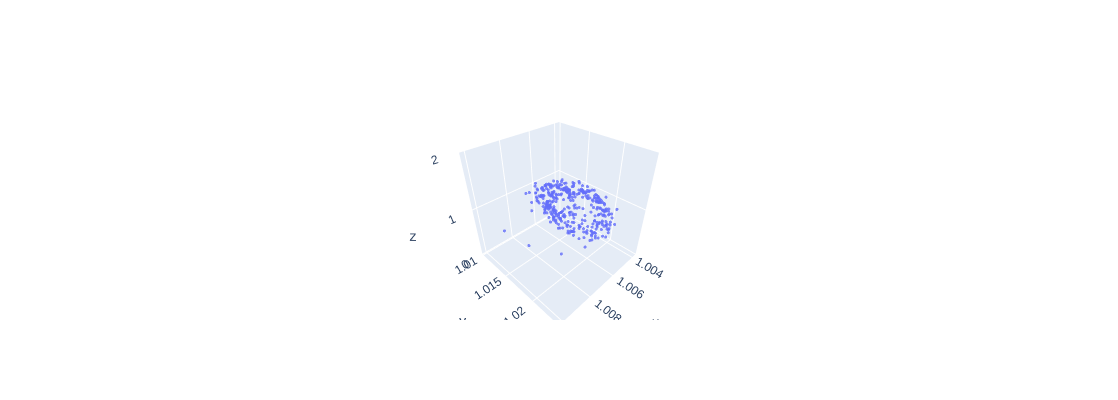

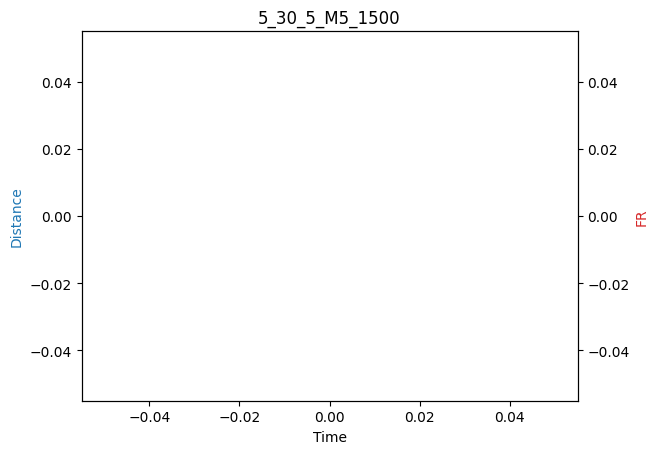

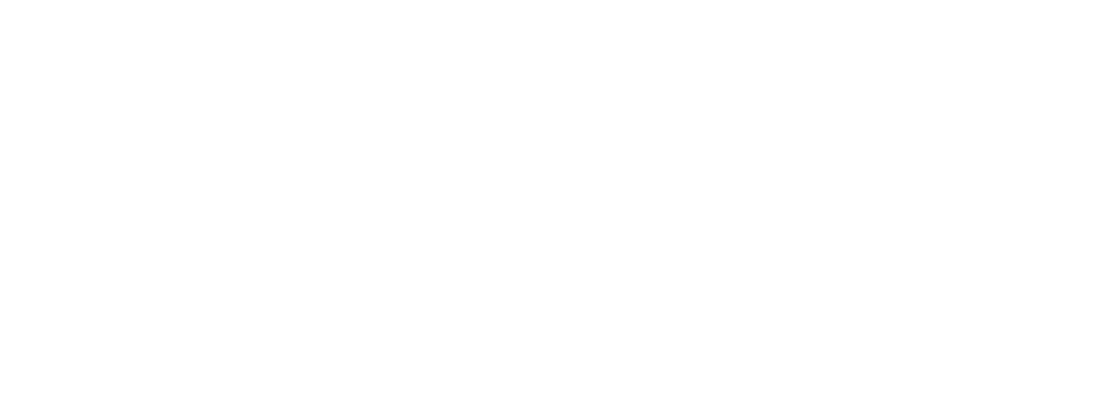

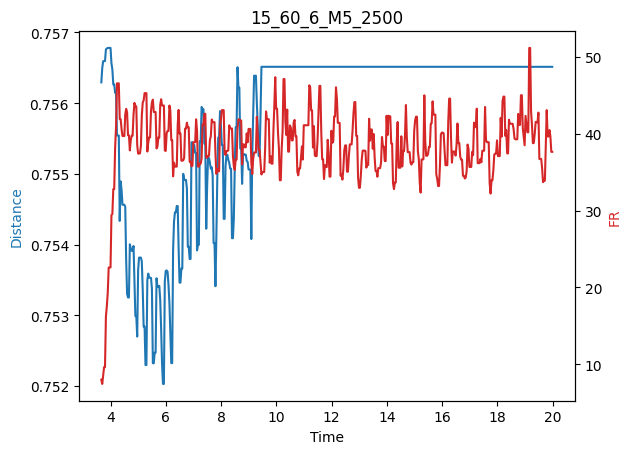

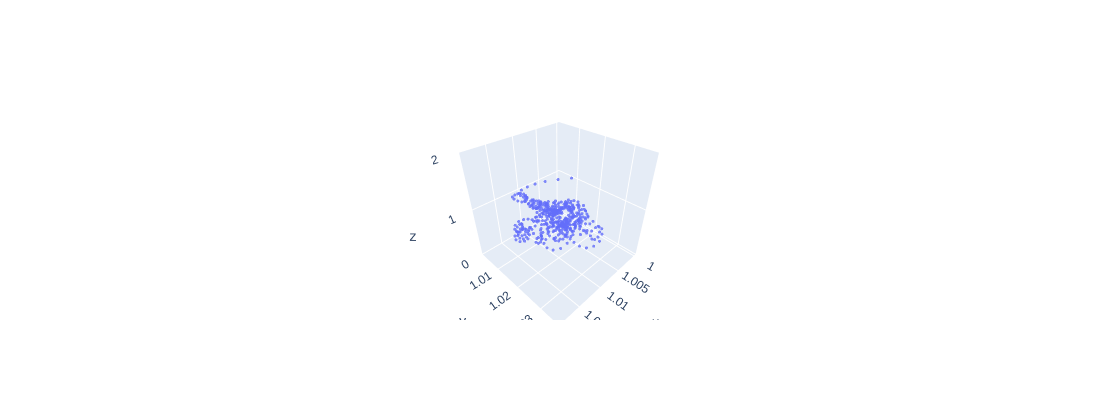

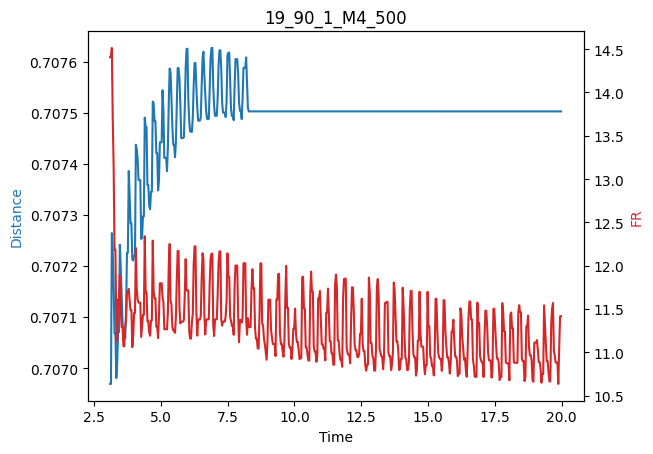

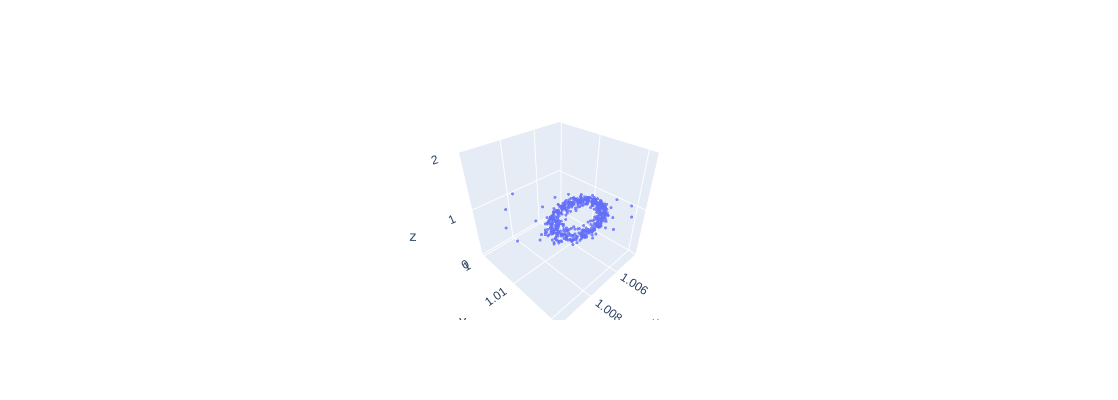

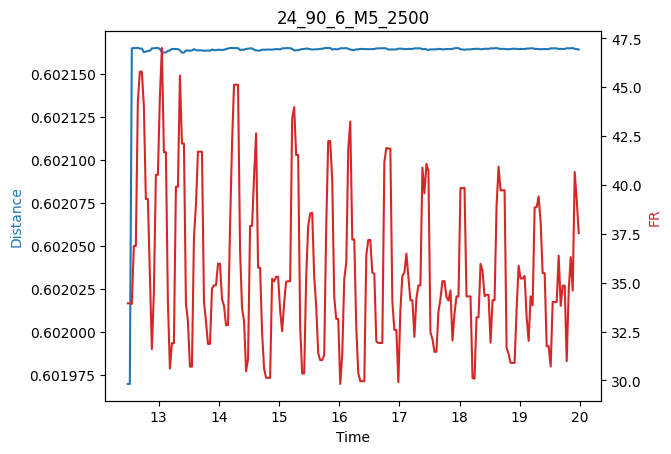

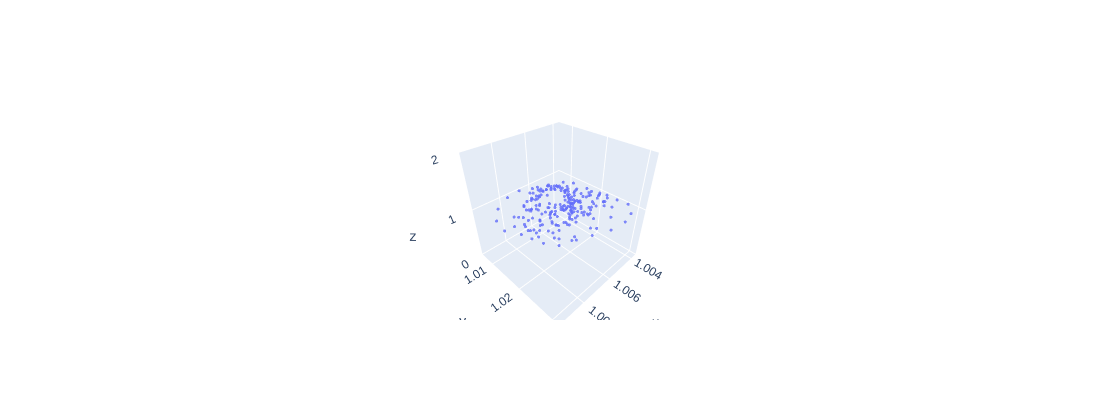

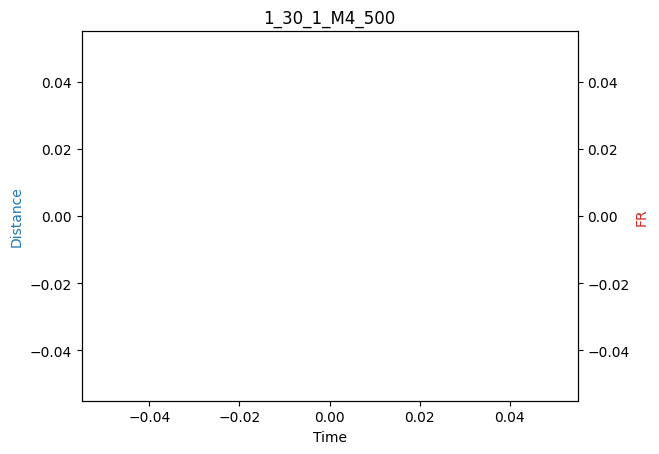

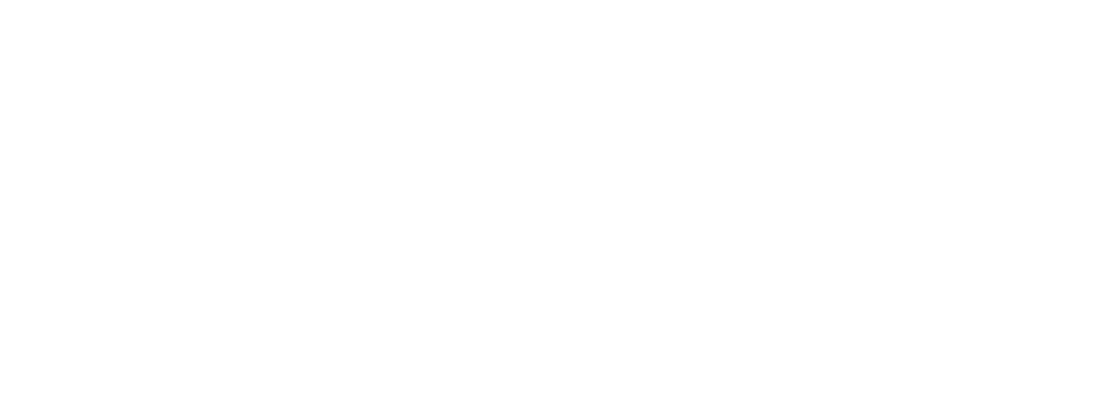

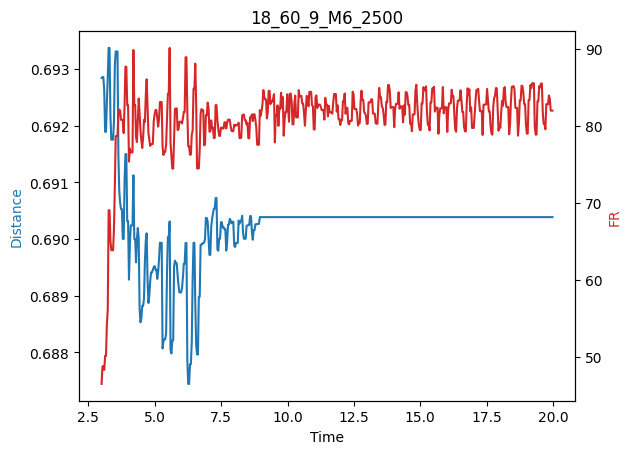

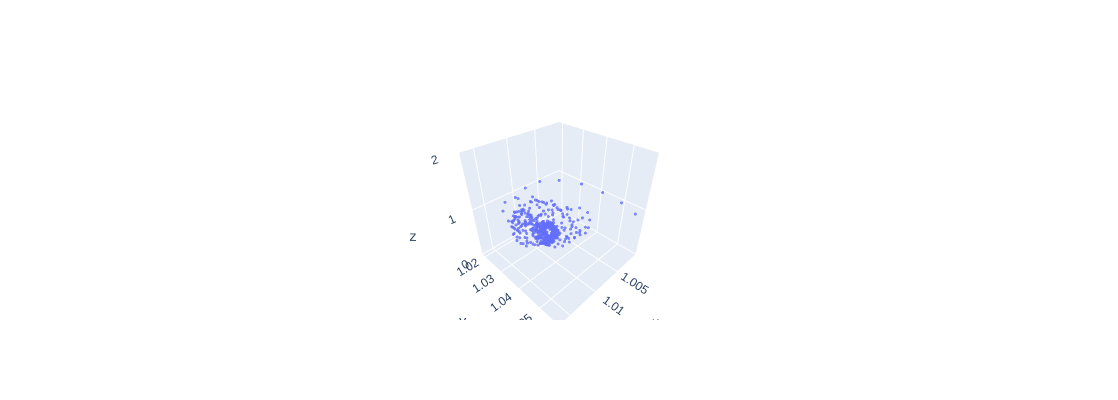

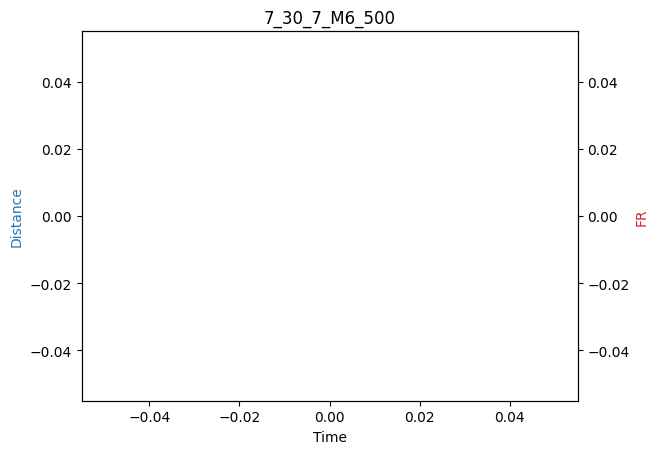

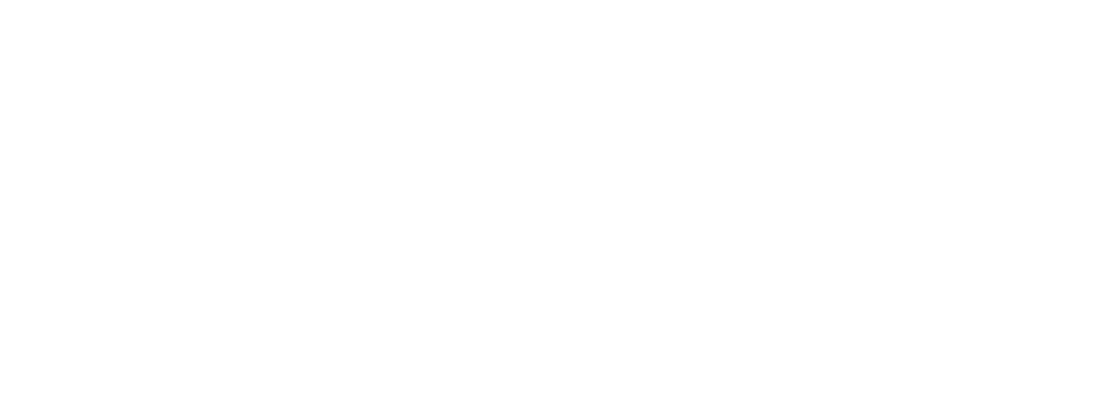

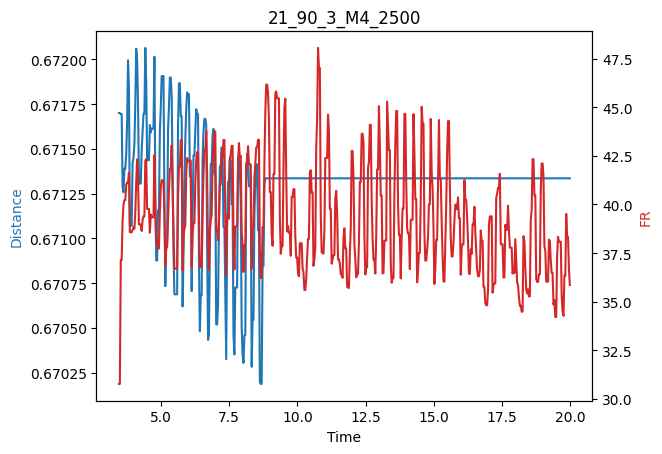

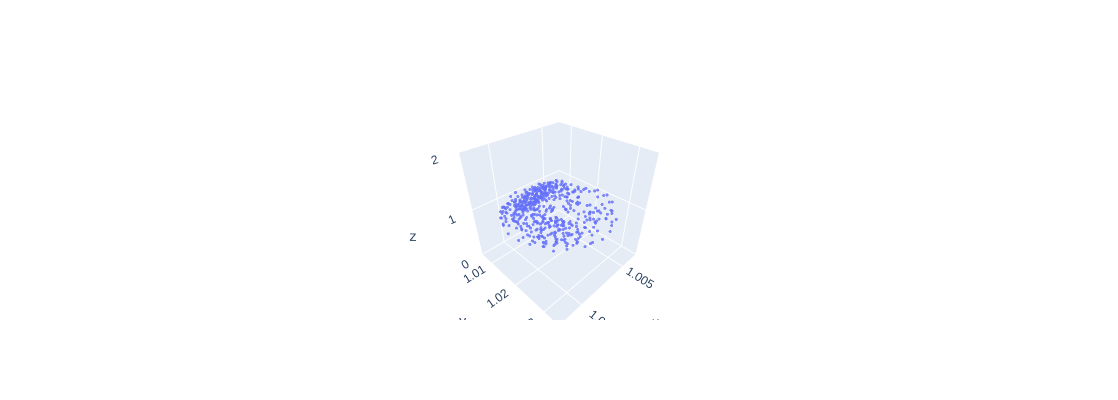

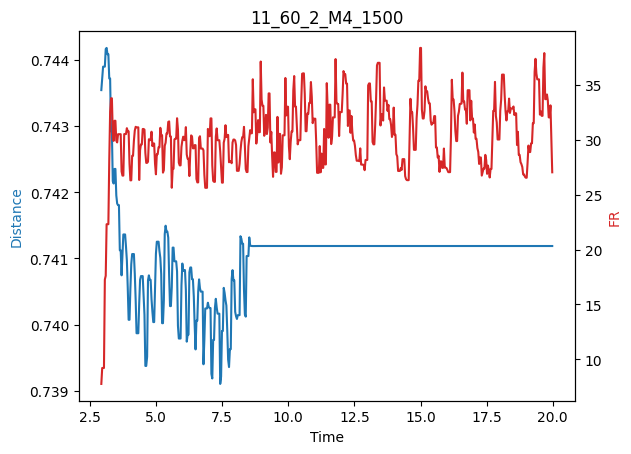

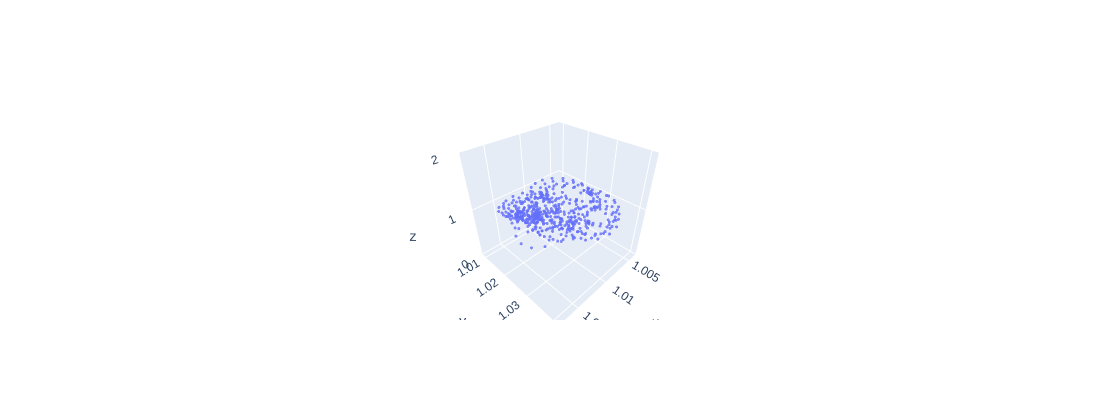

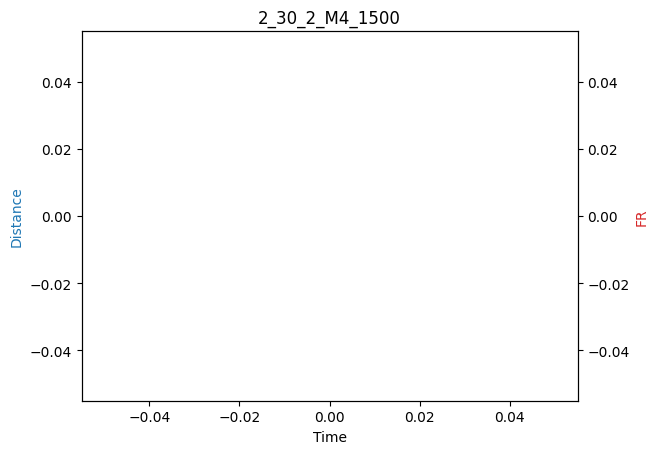

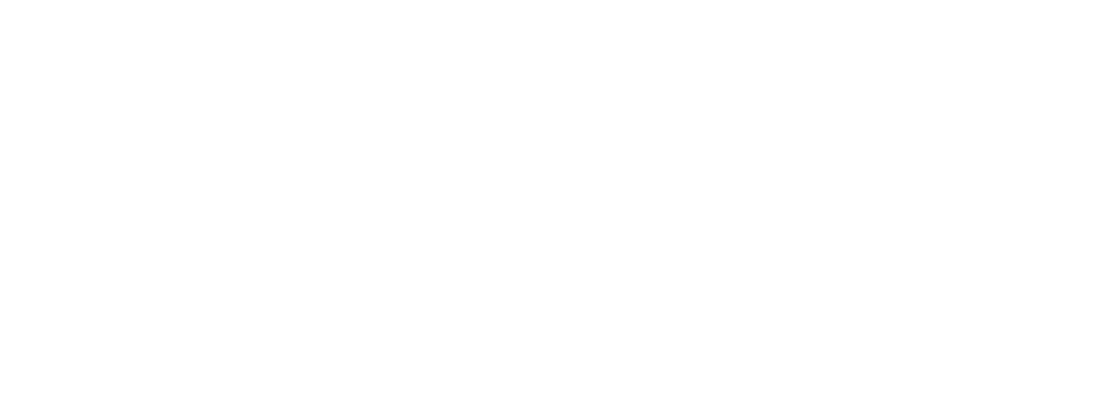

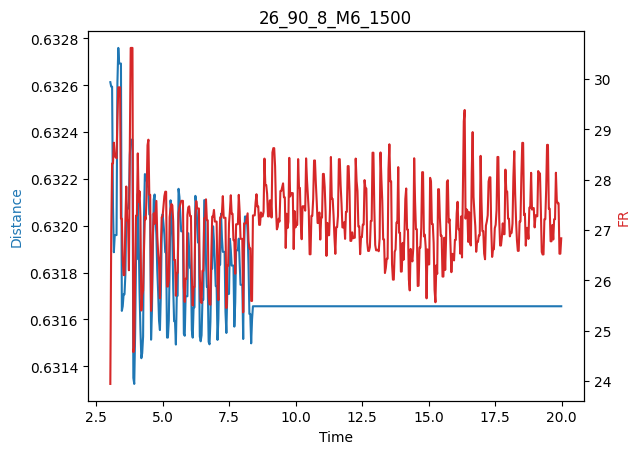

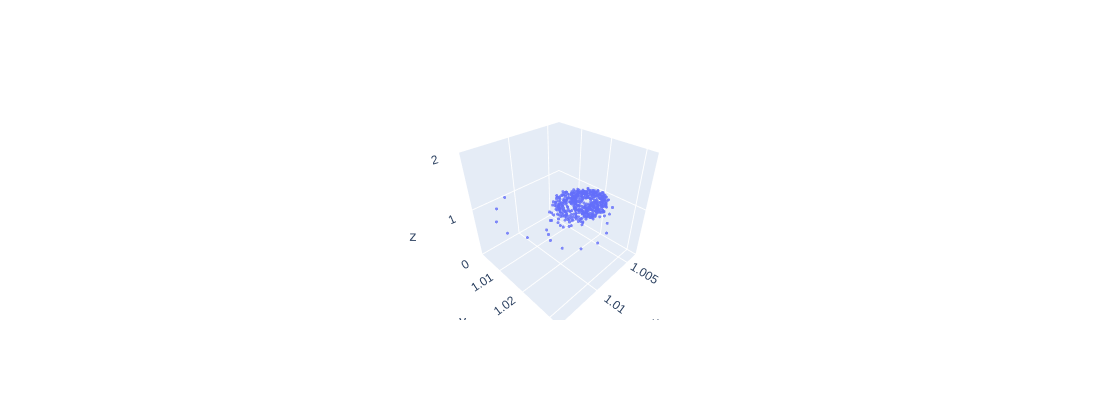

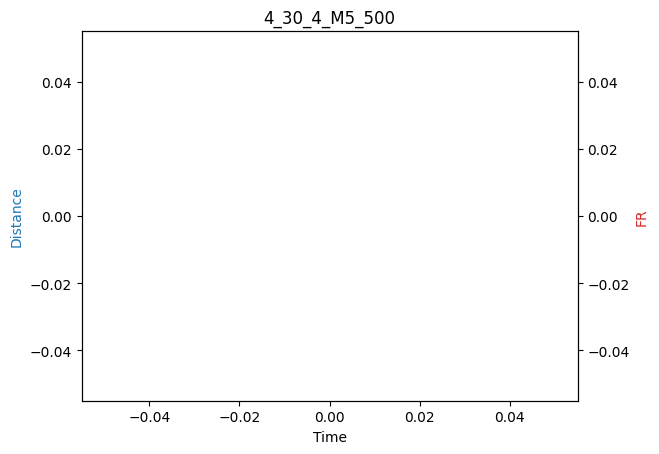

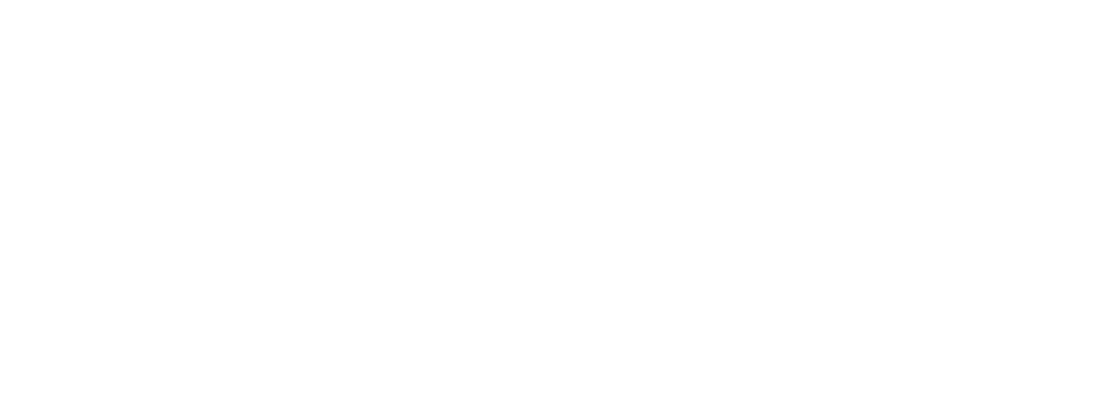

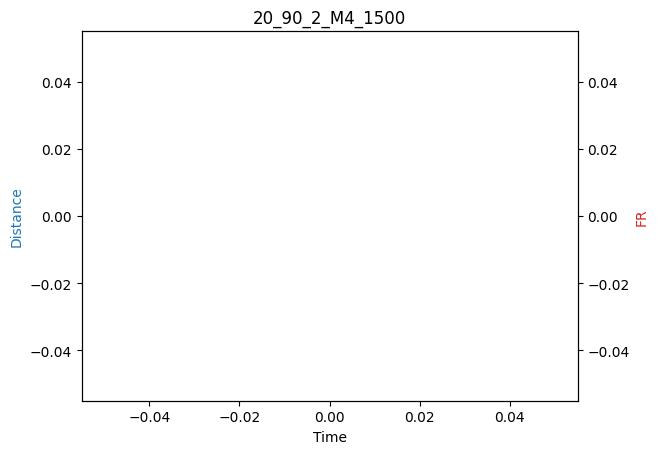

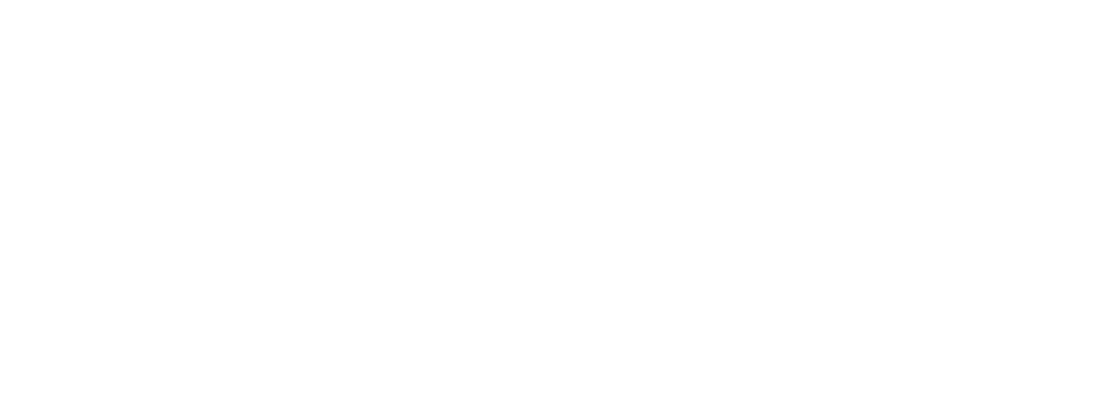

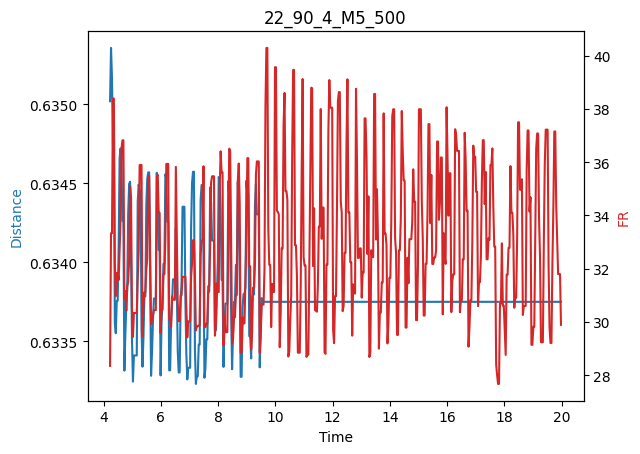

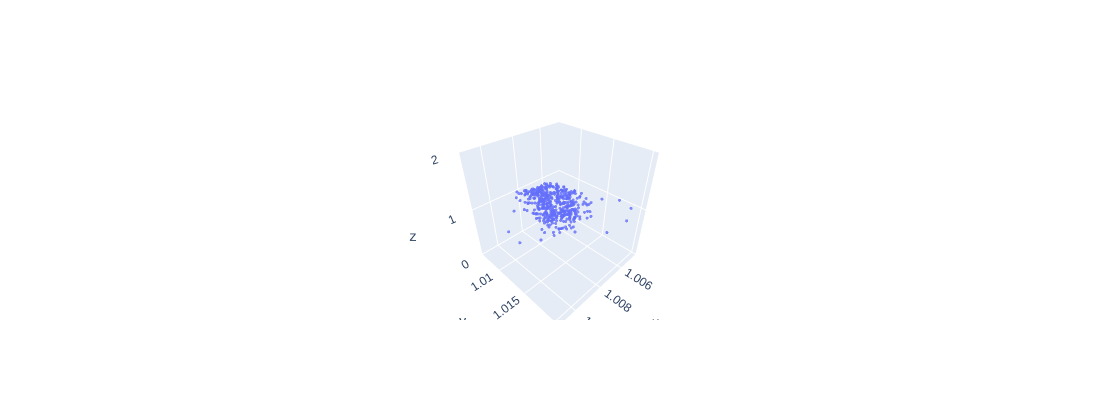

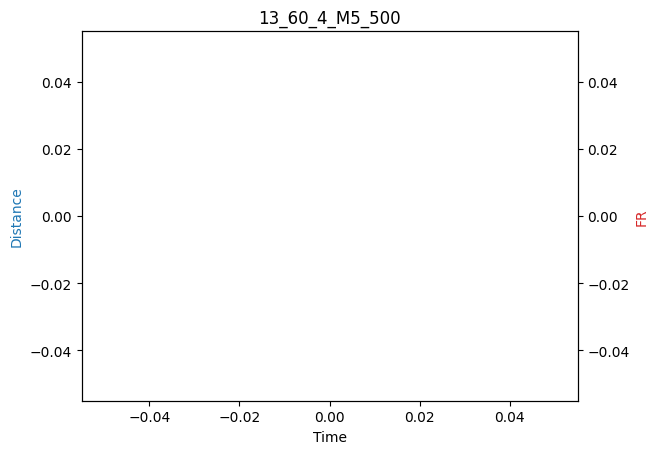

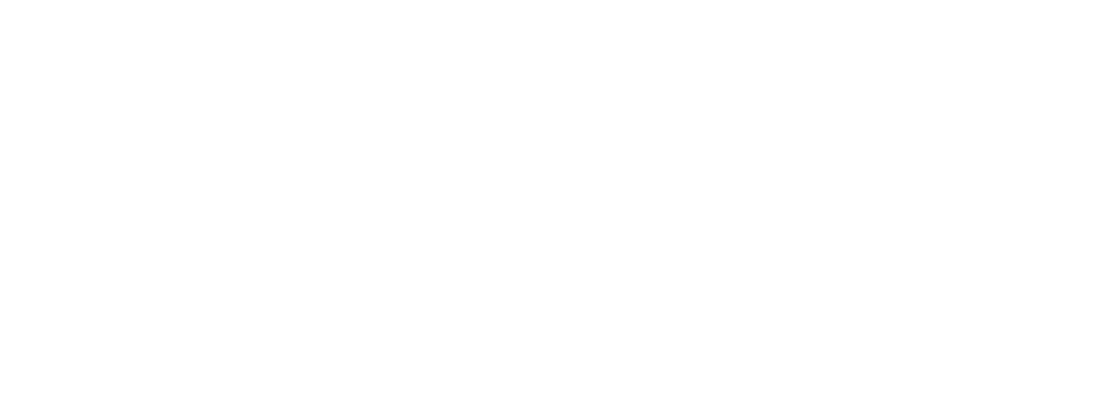

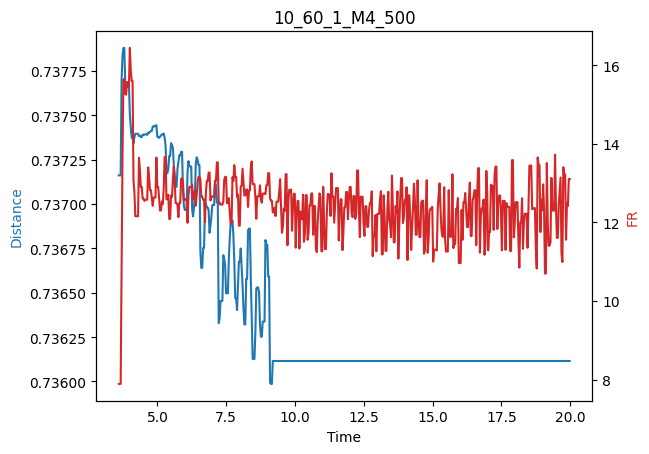

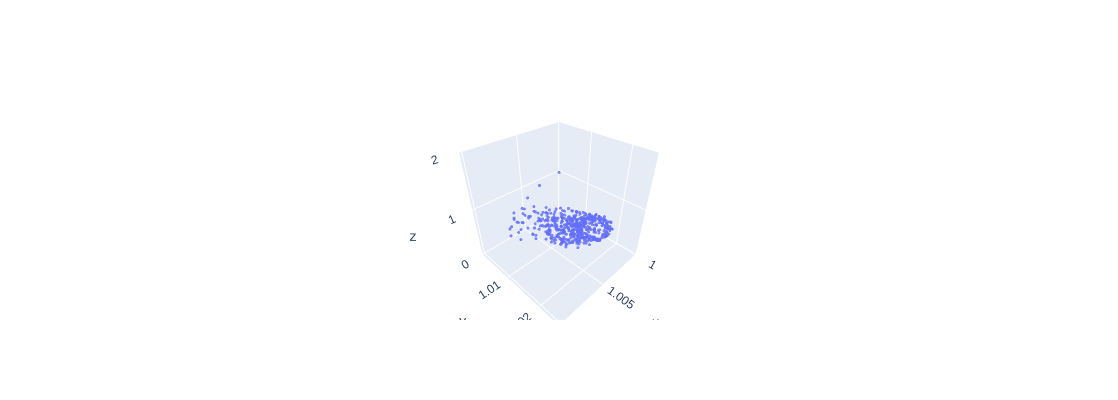

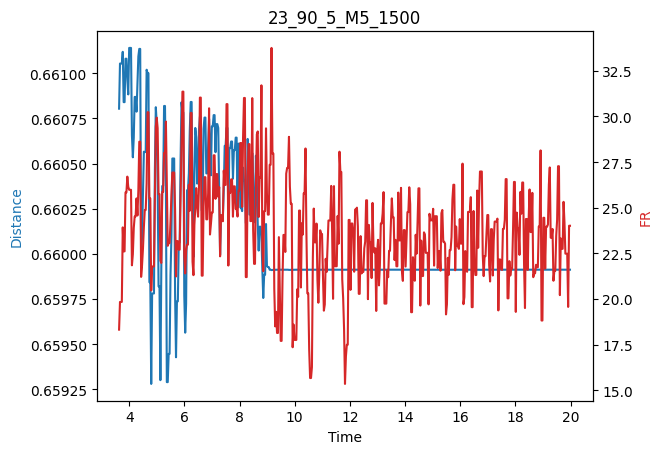

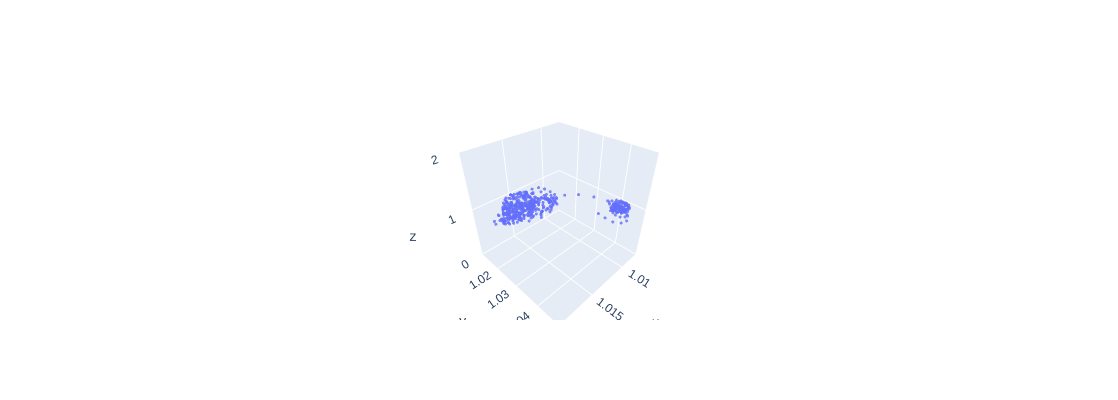

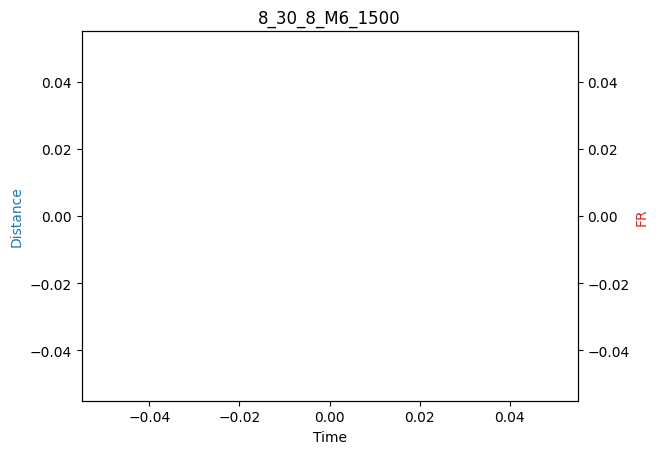

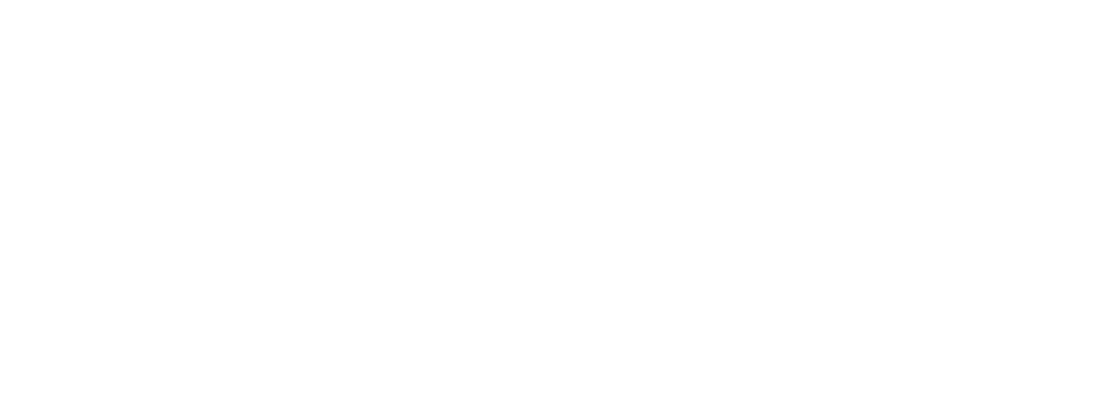

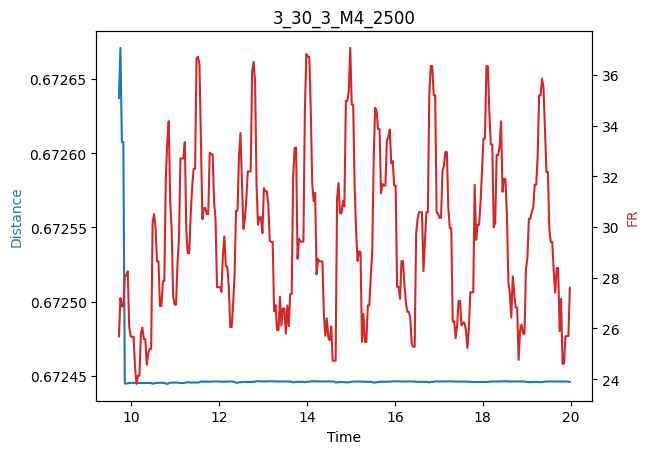

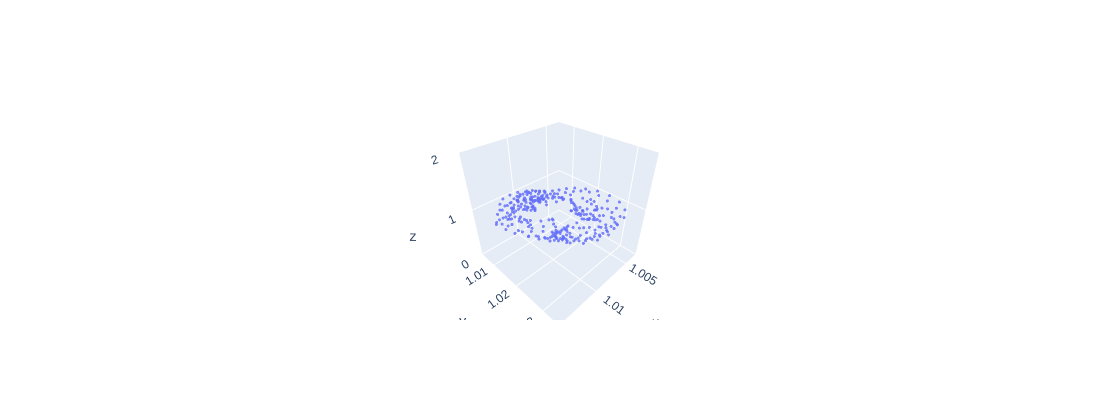

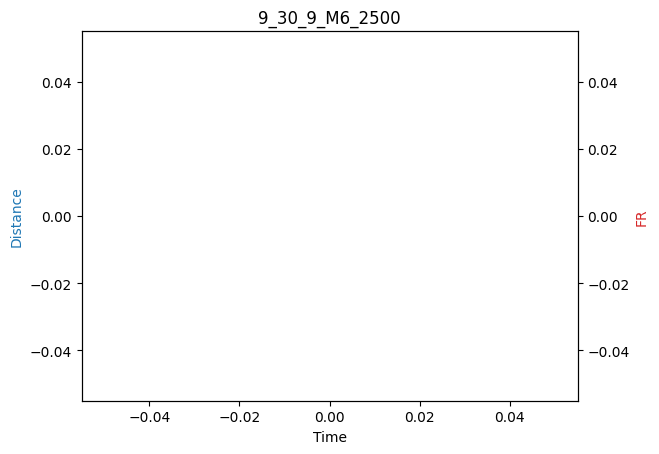

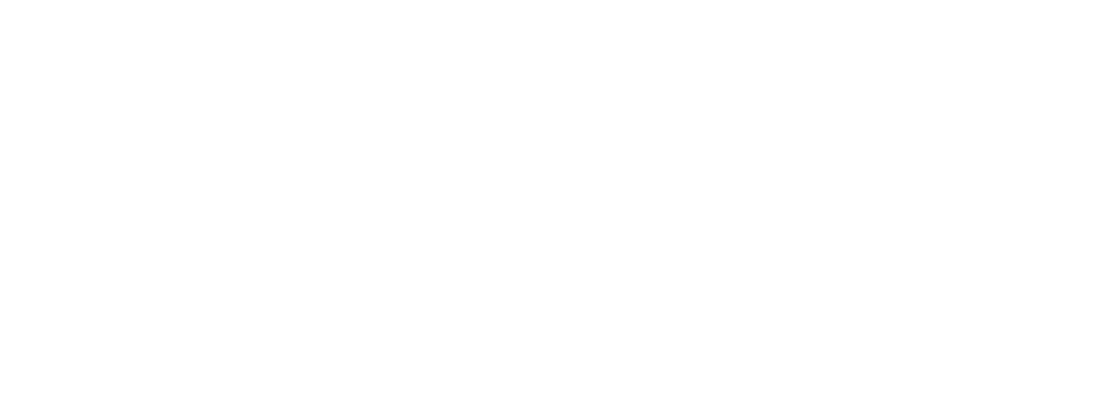

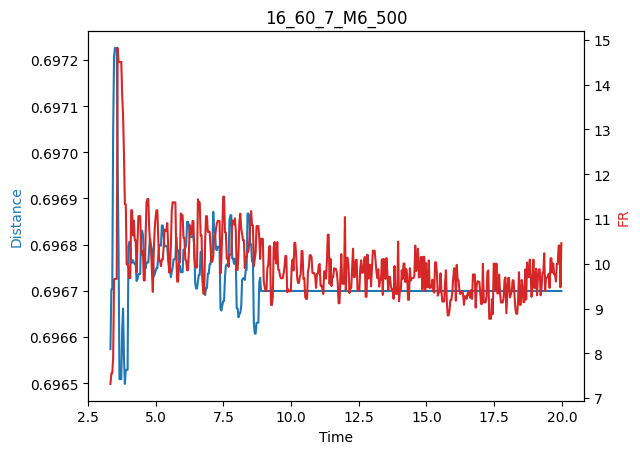

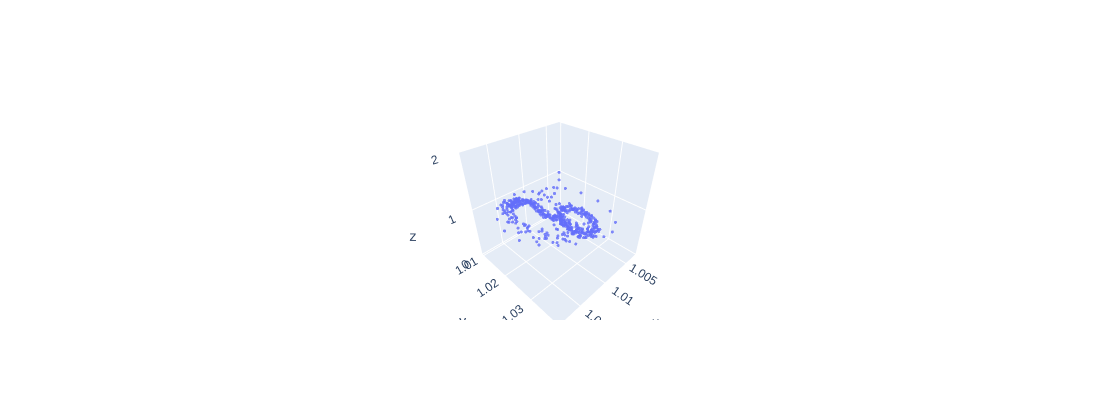

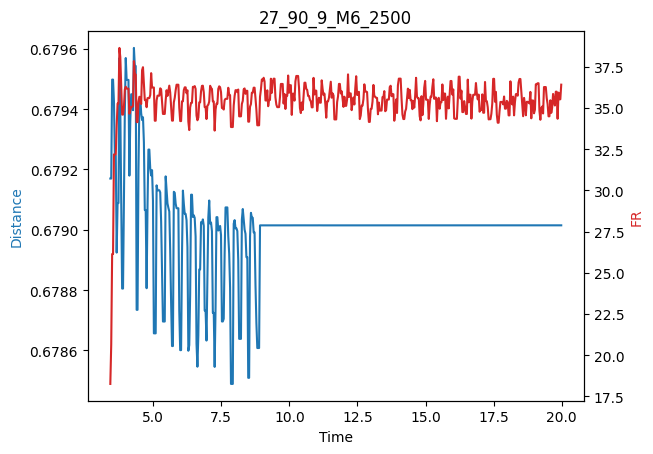

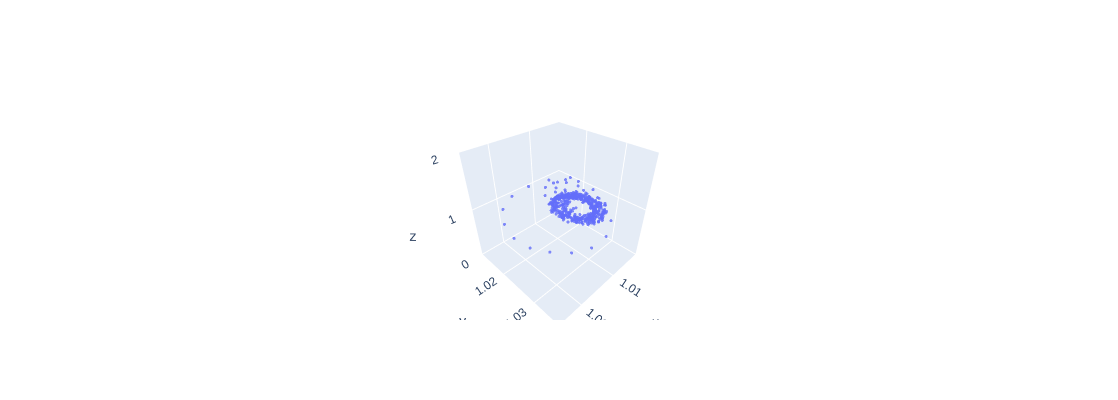

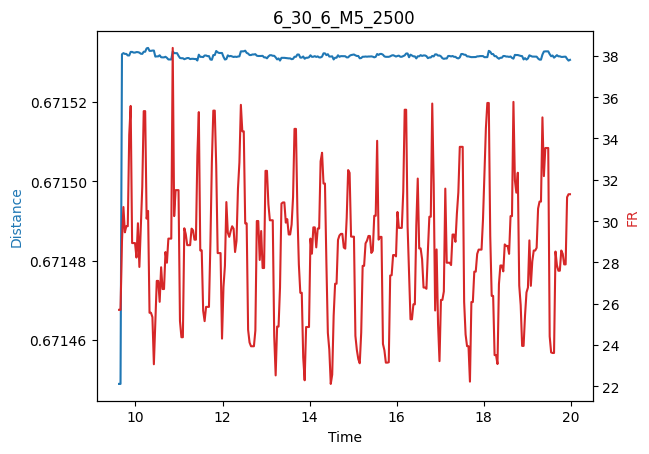

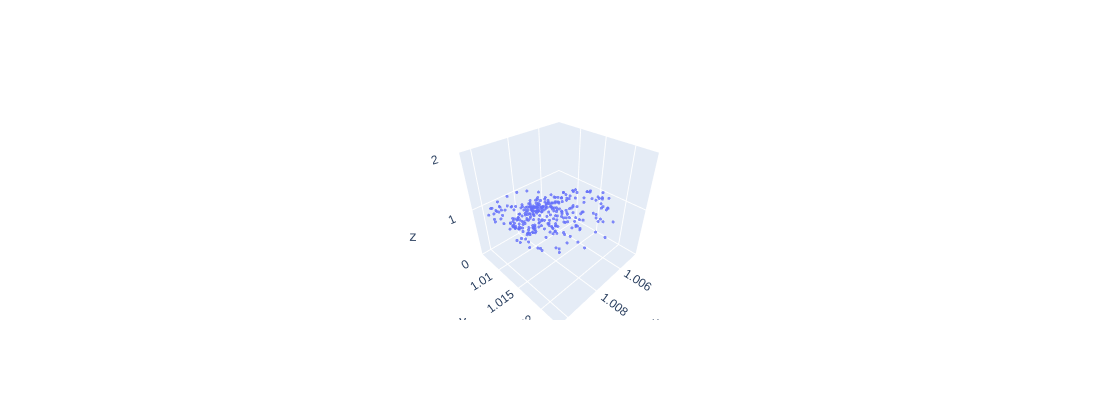

In [7]:
offset = -0.010  # seconds (sensor is this much time ahead of the camera, minus means behind; manually verified with the image timestamp)
df_list = []

for subdir in subdirs:
    observation_path = os.path.join(data_dir, subdir, observation_file)
    sensor_path = os.path.join(data_dir, subdir, sensor_file)
    
    obs_df = pd.read_csv(observation_path)
    sen_df = pd.read_csv(sensor_path)
    
    obs_df['time'] = pd.to_datetime(obs_df['time'], unit='ms')
    obs_df = obs_df.sort_values(by='time', ascending=True)
    obs_df['time'] = (obs_df['time'] - obs_df['time'].min()).dt.total_seconds()
    
    sen_df['time'] = pd.to_datetime(sen_df['time'])    
    sen_df['time'] = (sen_df['time'] - sen_df['time'].iloc[0]).dt.total_seconds()
    sen_df['time'] = (sen_df['time'] + offset)

    observation_path_out = os.path.join(data_dir, subdir, 'aligned_{}'.format(observation_file))
    sensor_path_out = os.path.join(data_dir, subdir, 'aligned_{}'.format(sensor_file))
    obs_df.to_csv(observation_path_out, index=False)
    sen_df.to_csv(sensor_path_out, index=False)

    sen_df['fr'] = np.sqrt(sen_df['fx'] ** 2 + sen_df['fy'] ** 2 + sen_df['fz'] ** 2)
    sen_df['dist'] = np.sqrt(sen_df['X'] ** 2 + sen_df['Y'] ** 2 + sen_df['Z'] ** 2)
    is_increasing = sen_df['dist'].iloc[-100:-1].mean() - sen_df['dist'].iloc[0:100].mean() > 0
    tp_idx = sen_df[sen_df['dist'] >= sen_df['dist'].max() * 0.999].index.min() if is_increasing else \
        sen_df[sen_df['dist'] <= sen_df['dist'].min() * 1.001].index.max()
    trim_time = sen_df['time'][tp_idx]
    
    tolerance = np.abs(offset)
    merged_df = pd.merge_asof(obs_df, sen_df.drop(columns=['X', 'Y', 'Z']), on='time', tolerance=tolerance, direction='nearest')
    merged_df = merged_df[merged_df['time'] >= trim_time]
    if merged_df.shape[0] > 0:
        merged_df['X'] = merged_df['X'] / merged_df['X'].max()
        merged_df['Y'] = merged_df['Y'] / merged_df['Y'].max()
        merged_df['Z'] = merged_df['Z'] / merged_df['Z'].max()
    merged_df = merged_df.dropna()
    merged_df.reset_index(drop=True, inplace=True)
    merged_path_out = os.path.join(data_dir, subdir, merged_file)

    
    for column in ['X', 'Y', 'Z']:
        merged_df[column] = merged_df[column].ewm(alpha=0.2).mean()

    fig, ax1 = plt.subplots()
    ax1.plot(merged_df['time'], merged_df['dist'], color='tab:blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Distance', color='tab:blue')
    ax2 = ax1.twinx()
    ax2.plot(merged_df['time'], merged_df['fr'], color='tab:red')
    ax2.set_ylabel('FR', color='tab:red')
    plt.title(subdir)
    plt.show()

    fig = go.Figure(data=[go.Scatter3d(
        x=merged_df['X'],
        y=merged_df['Y'],
        z=merged_df['Z'],
        mode='markers',
        marker=dict(
            size=1,
            opacity=0.8
        ),
    )])
    fig.update_layout(width=800, height=400)
    fig.show()

    merged_df.to_csv(merged_path_out, index=False)
    df_list.append(merged_df)


In [8]:
combined_df = pd.concat(df_list, ignore_index=True)
combined_df

time         X         Y    Z         A         B         C  \
0      3.829646  1.000000  1.016665  1.0 -1.415110  1.089467  0.186699   
1      3.862948  1.001954  1.012522  1.0 -1.415110  1.089467  0.186699   
2      3.896251  1.003726  1.009585  1.0 -1.416327  1.089622  0.184937   
3      3.929554  1.005090  1.007589  1.0 -1.416327  1.089622  0.184937   
4      3.962857  1.006170  1.006381  1.0 -1.416329  1.089577  0.183554   
...         ...       ...       ...  ...       ...       ...       ...   
8227  19.847650  1.008616  1.009736  1.0  3.078408  0.054515 -0.662638   
8228  19.880948  1.008996  1.008559  1.0  3.078408  0.054515 -0.662638   
8229  19.914247  1.009433  1.007403  1.0  3.078398  0.054518 -0.662642   
8230  19.947546  1.009774  1.006833  1.0  3.078396  0.054525 -0.662645   
8231  19.980844  1.009751  1.007731  1.0  3.078400  0.054525 -0.662643   

            Vx        Vy            Vz  ...  Rot_Cy  Rot_Cz      Kx      Ky  \
0    -0.005166 -0.033296 -2.045606e-02  ...     0.7     0.7   500.0   500.0   
1    -0.005166 -0.033296 -2.045606e-02  ...     0.7     0.7   500.0   500.0   
2    -0.005166 -0.033296 -2.045606e-02  ...     0.7     0.7   500.0   500.0   
3    -0.005166 -0.033296 -2.045606e-02  ...     0.7     0.7   500.0   500.0   
4     0.000953 -0.014961 -1.349340e-02  ...     0.7     0.7   500.0   500.0   
...        ...       ...           ...  ...     ...     ...     ...     ...   
8227 -0.000010 -0.000001  1.728571e-07  ...     0.7     0.7  2500.0  2500.0   
8228 -0.000010 -0.000001  1.728571e-07  ...     0.7     0.7  2500.0  2500.0   
8229 -0.000010 -0.000001  1.728571e-07  ...     0.7     0.7  2500.0  2500.0   
8230 -0.000010 -0.000001  1.728571e-07  ...     0.7     0.7  2500.0  2500.0   
8231 -0.000010 -0.000001  1.728571e-07  ...     0.7     0.7  2500.0  2500.0   

          Kz  Rot_Kx  Rot_Ky  Rot_Kz         fr      dist  
0      500.0   500.0   500.0   500.0   8.385174  0.755510  
1      500.0   500.0   500.0   500.0   8.385174  0.755510  
2      500.0   500.0   500.0   500.0   9.912632  0.755801  
3      500.0   500.0   500.0   500.0   9.912632  0.755801  
4      500.0   500.0   500.0   500.0  11.795994  0.755876  
...      ...     ...     ...     ...        ...       ...  
8227  2500.0  2500.0  2500.0  2500.0  27.904218  0.671531  
8228  2500.0  2500.0  2500.0  2500.0  27.904218  0.671531  
8229  2500.0  2500.0  2500.0  2500.0  31.157348  0.671531  
8230  2500.0  2500.0  2500.0  2500.0  31.300417  0.671530  
8231  2500.0  2500.0  2500.0  2500.0  31.300417  0.671531  

[8232 rows x 33 columns]

In [9]:
train_df, test_df = train_test_split(combined_df, test_size=0.2)
val_df, test_df = train_test_split(test_df, test_size=0.5)

print(train_df.shape, val_df.shape, test_df.shape)

(6585, 33) (823, 33) (824, 33)


In [10]:
train_file_path = os.path.join(out_dir, train_file)
val_file_path = os.path.join(out_dir, validation_file)
test_file_path = os.path.join(out_dir, test_file)

train_df.to_csv(train_file_path, index=False)
val_df.to_csv(val_file_path, index=False)
test_df.to_csv(test_file_path, index=False)